In [1]:
# Import libraries
%load_ext autoreload
from QDNotebooks.header import *

import sys
sys.path.append(r'C:\Users\MA-Qutau Admin\Documents\GitHub\qeg_rfsoc')
from rfsoc_lib.rfsoc_calibration import RfsocCalibration
from rfsoc_lib.rfsoc_pulses import RfsocPulses
from rfsoc_lib.rfsoc_arb_pulses import RfsocArbPulses

from peakutils import indexes
import seaborn as sns
plt.rcParams["grid.color"] = (0.5, 0.5, 0.5, 0.1)
custom_params = {
    "axes.grid": True,
}
sns.set_theme(style="ticks", palette="dark", rc=custom_params)
sns.set_context("poster")
import json
import elliptec
import QDServer.Utility.QDUtility as qdu
color_lst = sns.color_palette("dark", n_colors=10)

# import rpyc
# config = {"allow_public_attrs": True, "allow_all_attrs": True,"allow_setattr":True, "allow_delattr": True, "allow_pickle":True,"sync_request_timeout": 20}
# exp = rpyc.connect("localhost", port=12346, config=config).root
# import dill
# obtain = lambda obj: dill.loads(dill.dumps(obj)) # Do obtain(obj) to transfer obj from the server to here
import jstyleson
import pickle
import bisect
%matplotlib inline

# Initialize Equipment

In [2]:
counter = exp.get_device('Counter')
keithley = exp.get_device('Keithley')
pid = exp.get_device('SIM960')
ps = exp.get_device('PulseStreamer')
femto = exp.get_device('FemtoPD')
delaygen = exp.get_device('DelayGenerator')
laser2 = exp.get_device('DLpro') # remember to swap it back - laser 2 = Raman
laser1 = exp.get_device('TApro') # remember to swap it back - laser 1 = Resonant
rigol = exp.get_device('Rigol')
laser_lock = exp.get_device('NF1') 
counter.set_TriggerLevel(1, 0.3)
eom_pid = exp.get_device('SIM960Monk') # EOM lock PID w/ LockIn
keithley_sm = exp.get_device('KeithleySM')
DAQ = exp.get_device('RemoteNIDAQ')
try:
    rs_mw = exp.get_device('RohdeSchwarz')
    rs_mw.power_limits = [-30, 16]
except Exception as ep:
    print (ep)
    pass
try:
    controller = elliptec.Controller('COM14')
    hwp = elliptec.Rotator(controller, address='0')
    qwp = elliptec.Rotator(controller, address='1')
    clear_output(False)
    print (f'Current angle: HWP: {hwp.get_angle()}deg, QWP: {qwp.get_angle()}')
    # print (qw
except Exception as ep:
    print (ep)
finally:
    controller.close_connection()

TX: b'0gp'
RX: b'0PO00005461\r\n'
Status OK (position)
TX: b'1gp'
RX: b'1PO00004E54\r\n'
Status OK (position)
Current angle: HWP: 54.2436deg, QWP: 50.3538
Connection is closed!


In [3]:
# Board libraries
from qick import *
import Pyro4

# Pyro communicates with board
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

# Static IP proxy
ns_host = "172.24.106.21" # <-- SET IP ADDRESS
ns_port = 8888
proxy_name = "myqick"

# QICK object
ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
print(soccfg)


QICK configuration:

	Board: RFSoC4x2

	Software version: 0.2.267
	Firmware timestamp: Wed Sep  6 18:49:29 2023

	Global clocks (MHz): tProcessor 409.600, RF reference 491.520

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by output 7, pin 14, feedback to tProc input 0
		ADC tile 0, blk 0 is ADC_D
	1:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by o

In [39]:
with open(r'C:\Users\MA-Qutau Admin\Documents\GitHub\qeg_rfsoc\pickles\const_power.pickle', 'rb') as handle:
    const_power = pickle.load(handle)

with open(r'C:\Users\MA-Qutau Admin\Documents\GitHub\QDNotebooks\pulsemaker_config_cryo2.json') as json_file:
    config = jstyleson.load(json_file)


# Pulse Sequence

In [40]:
def raman_cooling_single_ramsey(ramsey_pi_half, ramsey_delay, ramsey_phase,analog_cool=0.12, analog_read=1, if_freq_GHz=3.0, if_cool_GHz=3.0 ,raman_cooling_length=37000, 
                              readout_length=2500, debug=False):
    global config, ps, info, data
    raman_ttl =  config['rfsoc_delay']['raman_ttl'] 
    pump_ttl = config['rfsoc_delay']['pump_ttl']
    pump_ana = config['rfsoc_delay']['pump_ana']
    buffer = config['buffer']
    end_delay = config['end_delay']
    awg = config['rfsoc_delay']['awg']


    awg_wait = (awg, 0)
    raman_cooling = (raman_cooling_length, 1.0, if_cool_GHz, 0)
    initialisation =(readout_length, 0)
    
    readout = (readout_length, 0)

    readout = (readout_length, 0)
    buffers = (buffer, 0)
    end = (end_delay, 0)

    rf_pulse_delay = 0

    pi_half_zero_phase = (ramsey_pi_half, 1.0, if_freq_GHz, 0)
    wait_time = (ramsey_delay, 0)
    pi_half_vary_phase = (ramsey_pi_half, 1.0, if_freq_GHz, ramsey_phase)

    total_length = ramsey_pi_half*2 + ramsey_delay
    pi_half_seq = RfsocArbPulses(soccfg,
                                 [pi_half_zero_phase, wait_time, pi_half_vary_phase],
                                 outsel='product',
                                 )#arb



   

    sequences = {'DAC_A': [buffers,  raman_cooling, buffers, 
                           buffers, initialisation, 
                           buffers, pi_half_seq, buffers,
                           buffers, readout ] }                   


    pulses = RfsocPulses(sequences,
                         const_power=const_power,
                         scale_power=1,
                         print_params=debug
                         )
    seq_length =  int(pulses.get_end_time()*1e3)
    
    raman_pulse = [(raman_ttl, 0)]
    raman_pulse.extend([(raman_cooling[0]+buffer+buffer, 1)])
    raman_pulse.extend([(buffer+initialisation[0], 0)])
    raman_pulse.extend([(total_length+ buffer+buffer, 1)])
    raman_pulse.extend([(buffer+readout[0], 0)])
    raman_pulse.extend([(end[0], 0)])
    
    rf_pulse = [(pump_ttl, 0)]
    rf_pulse.extend([(raman_cooling[0]+buffer*2, 1)])
    rf_pulse.extend([(buffer, 0)])
    rf_pulse.extend([(initialisation[0], 1)])
    rf_pulse.extend([(total_length + buffer*3, 0)])
    rf_pulse.extend([(readout[0], 1)])
    rf_pulse.extend([(end[0], 0)])
    
    analog_pulse = [(pump_ana, 0)]
    analog_pulse.extend([(raman_cooling[0]+buffer*3, analog_cool)])
    analog_pulse.extend([(initialisation[0], analog_read)])
    analog_pulse.extend([(total_length+ buffer*3, analog_read)])
    analog_pulse.extend([(readout[0], analog_read)])
    analog_pulse.extend([(end[0], 0)])
    
    seq = ps.device.createSequence() # create new sequence
    seq.setDigital(0,rf_pulse)
    seq.setDigital(1,raman_pulse)
    seq.setDigital(6, [(20, 1), (int(seq_length-20), 0)]) # trigger the time tagger
    seq.setDigital(2, [(20, 1), (int(seq_length-20), 0)]) # triggger the AWG/RFSoc
    seq.setAnalog(0, [ (int(seq_length), 1)])
    seq.setAnalog(0, analog_pulse)
    ps.play_seq(seq) 
    
    prog = QickProgram(soccfg)
    pulses.generate_asm(prog, reps=1)
    pulses.config_external_start(soc, prog)

    try:
        data['pump_ttl'] = rf_pulse
        data['pump_ana'] = analog_pulse
        data['raman_ttl'] = raman_pulse
        data['awg'] = [(20, 1), (int(seq_length-20), 0)]
        # data['awg_ttl'] = sequences
    except Exception as ep:
        print (ep)
        pass
    return seq_length

In [41]:
start_delay =  849
seq_length = raman_cooling_single_ramsey(ramsey_pi_half=15,
    ramsey_delay=0,
    ramsey_phase=90, raman_cooling_length=37000)

integration_time_s = 2
ch_trig = 6
ch_click = 4#1 #dd one to channel number of de~vice. # 2: SNSPD-ch1, 5: APD, 6: trigger mira
n_points = 50
bin_ns = 1
seq_length = seq_length
roi  = [start_delay//bin_ns]
roi = np.array(roi, dtype='int')
histogram = counter.create_Histogram(ch_trig=ch_trig, 
                                     ch_click=ch_click, 
                                     binwidth=bin_ns*1e3, 
                                     n_bins=int(1*seq_length/bin_ns))
histogram.startFor(int(integration_time_s*1e12), clear=True)
time.sleep(integration_time_s)
counts = np.asarray(histogram.getData())
time_ns = np.arange(len(counts))*bin_ns


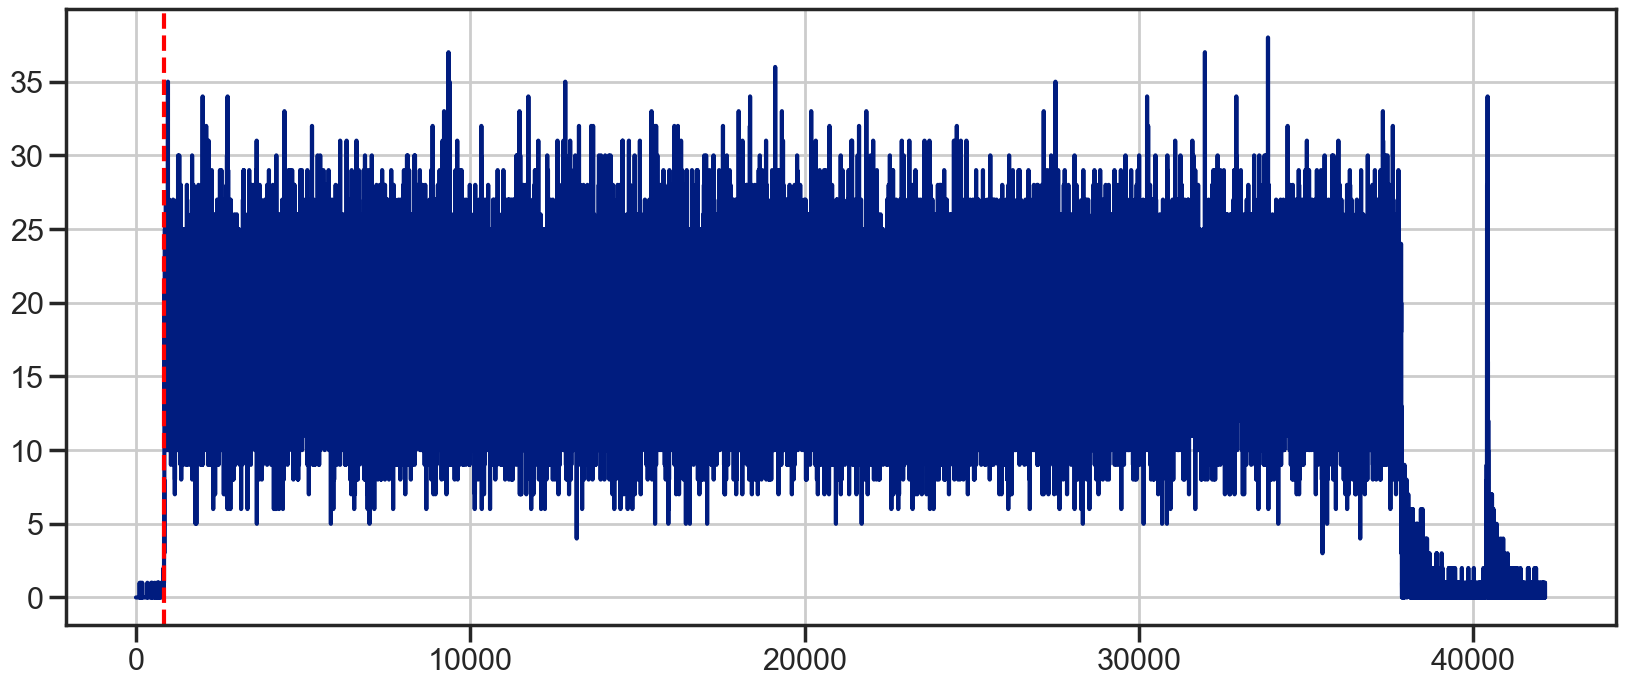

In [44]:
%matplotlib inline
import lazyfit
f = plt.figure(figsize=(20,8))
ax = f.add_subplot(111)
ax.plot(time_ns, counts)
for j in roi:
    ax.axvline(x=time_ns[j], color='red', ls='--')
#     ax.axvline(x=time_ns[j]+180, color='red', ls='--')
# try:
#     fit_EOM = lazyfit.fit('logpulse', time_ns, counts)
#     # fit_EOM.plot(xlabel='Time (ns)', ylabel='Counts', N=10000);#
#     print ('Rise time',lazyfit.utility.get_logistic_risetime(fit_EOM.params_dict['k0']))
#     print ('Start at',fit_EOM.params_dict['x0'])
#     print ('Measured End at',fit_EOM.params_dict['x1'])
#     # print ('Expected End at',fit_EOM.params_dict['x0']+raman_cooling[0])
#     # print ('Difference of {:.3f}ns'.format(fit_EOM.params_dict['x0']+raman_cooling[0]- fit_EOM.params_dict['x1']))
#     ax.axvline(x=fit_EOM.params_dict['x0'], color='red', ls='--')
#     ax.axvline(x=fit_EOM.params_dict['x1'], color='red', ls='--')
# except Exception as ep:
#     print (ep)

# Run measurement

In [45]:
import math
def roundup(x):
    return int(math.ceil(x / 100.0)) * 100

def get_counts(_counts, start_time_idx, pulse_width_idx):
    '''
    Return the counts from a histogram.
    input: _time_ns, _counts, start_time_ns, pulse_width_ns
    return : background corrected counts. Background is the last half of the histogram.
    '''
    start = int(start_time_idx)
    gap = int(pulse_width_idx/2)
    return np.sum(_counts[start:start+gap]) - np.sum(_counts[start+gap:start+gap+gap])
    
def calibration_bias(voltage_source, histogram, key_info, integration_time_s=1, seq_length=None, debug=False):
    '''
    This step serves as a calibration step to optimize the gate voltage
    before the real long experiment starts.
    For this, the protocol involves first setting up a custom waveform on all 3 channels (digital, analog),
    sweep the bias from the bias_sweep array, and get the counts from the histogram of the initialization,
    within 1s of integration time.
    This function returns the bias that corresponds to maximum counts.
    '''

    bias_sweep = key_info['bias_sweep']
    roi = key_info['roi']
    
    counts = np.zeros(len(bias_sweep))
    for j, _bias in enumerate(bias_sweep):
        print (f'Set to {_bias:.4f}V', end='\r')
        voltage_source.set_dc(_bias)
        time.sleep(0.1)
        # counts[j] = counter.get_countrate(info['det_ch'])
        histogram.clear()
        histogram.startFor(int(integration_time_s* 1e12), clear=True) 
        time.sleep(integration_time_s)
        _counts = np.asarray(histogram.getData())
        counts[j] = get_counts(_counts, roi[0], roi[1])
    if seq_length is not None:
        _num_rep = 1*1e9/seq_length
    else:
        _num_rep = 1*1e9/data['seq_length']
    print (counts/_num_rep)
    if debug:
        return bias_sweep[np.argmax(counts)], (counts/_num_rep), _counts
    else:
        return bias_sweep[np.argmax(counts)], max(counts/_num_rep)

# _,__outputconts,__histogram = calibration_bias(keithley, histogram, bias_calibration, debug=True)

In [48]:
### import time
linear_h = [39.239, 0.349]
waveplate_combination = [[30, 140],[15,50]] # [[30, 135],[34, 129]]
                         #[[32.5, 135]] # [[32.5, 135]] # [[57.5, 45]] #[[32.5, 135]]
idx = 1

try:
    controller = elliptec.Controller('COM14')
    hwp = elliptec.Rotator(controller, address='0')
    qwp = elliptec.Rotator(controller, address='1')
    clear_output(False)
    
    hwp.set_angle(waveplate_combination[idx][0]+linear_h[0])
    qwp.set_angle(waveplate_combination[idx][1]+linear_h[1])
    time.sleep(1)
    print (f'Current angle: HWP: {hwp.get_angle()}deg, QWP: {qwp.get_angle()}')
except Exception as ep:
    print (ep)
finally:
    controller.close_connection()
    


cooling_ratio = 0.9
str_cooling_ratio = str(cooling_ratio).replace('.', 'p')
raman_cooling = True
if raman_cooling:
    cooling_type = 'Raman'
else:
    cooling_type = 'Ramsey'


keyword = 'HWP_{:.3f}deg_QWP_{:.3f}deg'.format(waveplate_combination[idx][0]+linear_h[0]
                                      ,waveplate_combination[idx][1]+linear_h[1]) # ''Elliptical_QWP_75deg_HWP_34deg'

integration_time_s = 1
num_trials = 1

meastype = 'Ramsey'
info = {'int_time': integration_time_s,
        'num_trials': num_trials,
        'sample': 'Cryo2',
        'b_field': 3.5,
        'scantype': f'{meastype}_FrequencyPowerSweep_{str_cooling_ratio}{cooling_type}Cooling_{keyword}', #'SpinPumping_1p0Ve-9_311p135THz_Locked_Filtered_Raman', # 'ODMR_Multiple_1p0Ve-9_8uWRaman_FreqPulseLengthSweep', #'SpinPumping_1p0Ve-9_311p135THz_Locked_Filtered_Raman' , #'ODMR_Multiple_1p0Ve-9_10uWRaman_FreqPulseLengthSweep', # 'SpinPumping_1p0Ve-9_V3', # 'ODMR_Single_1p0Ve-9_1p3uWRaman',
        'suffix': 'Chef21_QD3',
        'det_ch': 4, # 1,
        'bin_ns': 10,
        'PD_gain': 4, 
        'laser2': 306840, # laser2.get_input(),
        'laserlocked': laser_lock.get_input(),
        'laser1': 307445, # 311134, # 316450,
        'PID_ch1': 1, # Resonant
        'PID_ch2': 0 , # Raman
        'PID_setpoint2': [1.4], # [9.2],
        'PID_setpoint1': None,
        'MW_power_dBm': 15,
        'lo_freq_GHz':17.5,
        'analog_cool': np.arange(0.12, 0.12+0.05/2, 0.05), 
        'analog_readout': 1,
        'if_amp':0.7}



freq_cooling_ghz = 29.0
mw_freq_GHz = np.arange(freq_cooling_ghz-0.2*0, freq_cooling_ghz+0.2*0 + 0.005/2, 0.005)/2 #  np.arange(28.0-1*0.5, 31.5+0.05/2, 0.05)/2  # [15.15]  # 

data = {'gate_voltages':  np.arange(-0.261, -0.261+0.001/2, 0.001) , 
        'mw_freq_Ghz': mw_freq_GHz,
        'rpanalogout_voltages': None,
        'freq_cooling_GHz':freq_cooling_ghz/2, 
        'amp_cooling':1,
        'rf_readout': 2e3,
        'raman_cooling': 21.5e3, # 91.5e3,
        'raman_drive': 0.5e3,
        'ps_analog_0': 0.,
        'raman_cooling_readout_ratio': 1,
        'cooling_fraction': cooling_ratio,
        'PID_setpoint2': info['PID_setpoint2'], 
        'lo_freq_GHz': info['lo_freq_GHz'],
        'delays':  np.arange(0., 5+0.25/2, 0.25),
       'phase':np.linspace(0, 540, 31),
       'pi_2_time':np.arange(15, 15+0.5/2, 0.5)}



total_sequence_length = data['rf_readout']*2
total_cooling = int((cooling_ratio/(1-cooling_ratio))*total_sequence_length)
raman_cooling = int(total_cooling*data['raman_cooling_readout_ratio'])
data['total_cooling'] = int(total_cooling + (roundup(raman_cooling) - raman_cooling))
data['raman_cooling'] = int(roundup(raman_cooling))

folder = f'Z:/RawData/{dt.datetime.today().strftime("%Y/%m/%d/CRYO1/%H%M%S_Ramsey")}'

ResonantLaser = laser_locking(laser1)
ResonantLaser.set_to_laserfreq(float(info['laser1']))

RamanLaser = laser_locking(laser2)
RamanLaser.set_to_laserfreq(float(info['laser2']))

ps = exp.get_device('PulseStreamer') # get the pulse streamer

femto = exp.get_device('FemtoPD')
gain = info['PD_gain']
if gain < 5:
    speed_type = 'L'
else:
    speed_type = 'H'
try:
    femto.set_param('gain', 'e%.0f'%int(gain))
    femto.set_param('speed', speed_type)
    femto.set_param('acdc', 'DC')
except:
    femto.set_param('speed', speed_type)
    femto.set_param('gain', 'e%.0f'%int(gain))
    femto.set_param('acdc', 'DC')


parameter1 = info['analog_cool'] # data['PID_setpoint2']
# meastype = 'PulseWidthSweep'
print ('Number of microwave freq are {}'.format(mw_freq_GHz.shape[0]))
print ('Number of sweeps are {}'.format(len(parameter1)))
# print ('Number of pulse delays are {}'.format(len(data['pulse_length'])))
# print ('Measurment duration is {}.'.format(mw_freq_GHz.shape[0]*info['int_time']*len(data['pulse_length'])))



TX: b'0ma0000545F'
RX: b'0PO00005461\r\n'
Move Successful.
TX: b'1ma00004E52'
RX: b'1PO00004E53\r\n'
Move Successful.
TX: b'0gp'
RX: b'0PO00005461\r\n'
Status OK (position)
TX: b'1gp'
RX: b'1PO00004E54\r\n'
Status OK (position)
Current angle: HWP: 54.2436deg, QWP: 50.3538
Connection is closed!
Number of microwave freq are 1
Number of sweeps are 1


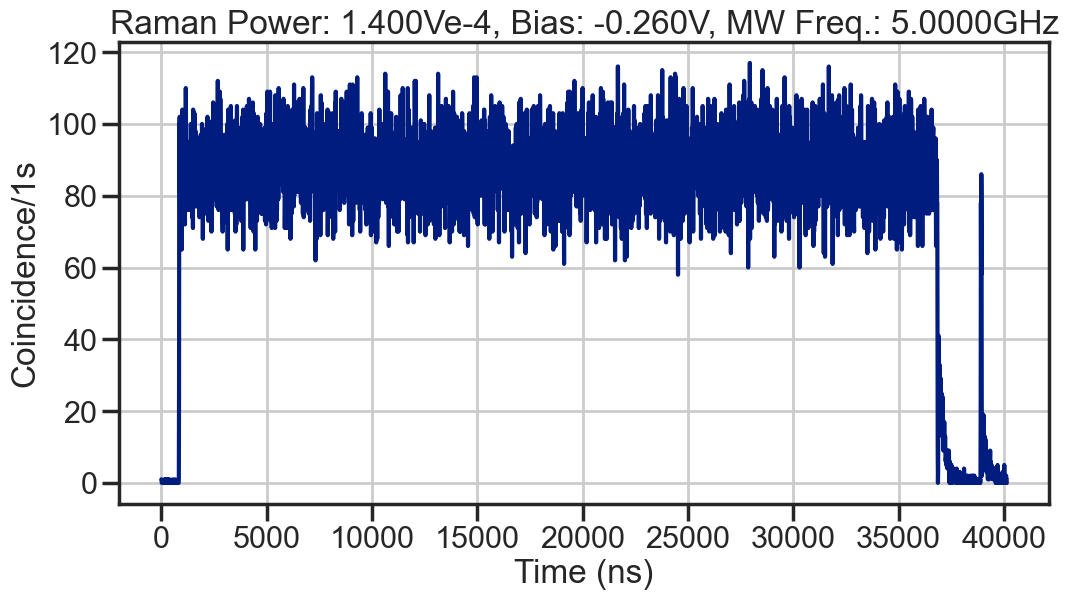

In [49]:
%matplotlib inline
sourcemeter = False
start_delay = 420
start_index = start_delay//info['bin_ns'] + data['total_cooling']//info['bin_ns']

seq_length = raman_cooling_single_ramsey(
   ramsey_pi_half=float(data['pi_2_time'][0]),
    ramsey_delay=float(data['delays'][0]),
    ramsey_phase=float(data['phase'][0]),
    analog_cool=float(info['analog_cool'][0]),
    analog_read=info['analog_readout'],
    if_freq_GHz=data['lo_freq_GHz'] - data['mw_freq_Ghz'][0],
    if_cool_GHz=data['lo_freq_GHz'] - data['freq_cooling_GHz'],
    raman_cooling_length=data['total_cooling'],
    readout_length=data['rf_readout'],debug=True)
data['seq_length'] = seq_length
pump_ttl_timing = np.array(data['pump_ttl'])[:,0]
index = np.where(pump_ttl_timing == int(data['rf_readout']))[0][-2:]
roi = [start_delay//info['bin_ns'] + pump_ttl_timing[:index[0]].sum()//info['bin_ns']]
roi.append(start_delay//info['bin_ns'] + pump_ttl_timing[:index[1]].sum()//info['bin_ns'])


threshold = 0.025
bias_start = -0.265
bias_stop = -0.250
bias_step = 0.001
integration_time_s = 0.5
start_index = roi[0]
roi_start = start_index
roi_end =  int(0.5*data['rf_readout']/info['bin_ns'])
bias_calibration = {'bias_sweep': np.arange(bias_start, bias_stop+bias_step/2, bias_step),
                'roi': [roi_start, roi_end],
                'custom_waveform': None}


data['valid'] = []
pid.set_manual_out(info['PID_ch2'], 2.1)
time.sleep(2)
lockpoint = pid.measure(info['PID_ch2'])


curVolt = None
bias_optimization = True


fig0 = plt.figure(figsize=(12,6))
r = data['PID_setpoint2'][0]
for kk, r in enumerate(data['PID_setpoint2']):
    
    histogram = counter.create_Histogram(ch_trig=6, 
                                         ch_click=info['det_ch'], 
                                         binwidth=info['bin_ns']*1e3, 
                                         n_bins=int(data['seq_length']/info['bin_ns']))
    
    print (f'Raman Power locked to %.3fV'%(lockpoint))
    pid.lock_to(info['PID_ch2'], lockpoint)
    time.sleep(1)
    #clear_output(True)
    for k, v in enumerate(data['gate_voltages']):  
        print (k, v)
        if bias_calibration is not None and curVolt is None:
            curVolt = v
        else:
            curVolt = v
        if sourcemeter:
            print (f'Voltage SM set to {v:.4f}V')
            keithley_sm.set_dc(v)
        else:
            print (f'Voltage AWG set to {v:.4f}V')
            keithley.set_dc(v)
        cummalative_data = []
        single_shots = []
        valid_data = []
        readout_counts = []
        for j, g in enumerate(data['delays']):
            
            if meastype == 'Ramsey':
                for il, _width in enumerate(data['phase']):
                    # if int(_width) != 11:
                    #     continue
                        
                    if cooling_type == 'Raman':
                        seq_length = raman_cooling_single_ramsey(
                                   ramsey_pi_half=float(data['pi_2_time'][0]),
                                    ramsey_delay=float(data['delays'][j]),
                                    ramsey_phase=float(data['phase'][il]),
                                    analog_cool=float(info['analog_cool'][0]),
                                    analog_read=info['analog_readout'],
                                    if_freq_GHz=data['lo_freq_GHz'] - data['mw_freq_Ghz'][0],
                                    if_cool_GHz=data['lo_freq_GHz'] - data['freq_cooling_GHz'],
                                    raman_cooling_length=data['total_cooling'],
                                    readout_length=data['rf_readout'],)
                   
                    # pw = [_width, float(data['pulse_length'][0]+data['pulse_length'][-1]) - _width]
                    print (f'MW Set to {g:.3f}GHz, Set to {g:.3f}ns delays {_width:.0f} phase, Raman Power locked to %.3fV'%(lockpoint))
                    time.sleep(2.5)
                    if j+il==0: 
                        if bias_calibration is not None:
                            print ('Bias calibration starts.')
                            if sourcemeter:
                                voltage_source = keithley_sm
                            else:
                                voltage_source = keithley
                            
                            time.sleep(0.1)
                            optimal_voltage, _ = calibration_bias(voltage_source, histogram, key_info=bias_calibration,
                                                                  integration_time_s=integration_time_s, seq_length=data['seq_length'])
                            curVolt = optimal_voltage
                            print (f'Optimal voltage found at {curVolt:.3f}V')
                            voltage_source.set_dc(np.round(curVolt,5))
             
                    
            
                    individual_slice = []
                    start = time.time()
                    repeat = 2
                    flag = True
                    _valid = []
                    
                    for _index in range(info['num_trials']):
                        while True:
                            histogram.clear()
                            histogram.startFor(int(info["int_time"]* 1e12), clear=True)   
                            time.sleep(info['int_time'])
                            output = np.asarray(histogram.getData())
                            num_rep = info["int_time"]*1e9/data['seq_length']
                            __counts = get_counts(output, start_index , data['rf_readout']/info['bin_ns'])/num_rep
                            
                            if  __counts < threshold:
                                if bias_optimization == False:
                                    break
                                print (f'Counts {__counts:.4f} low. Bias calibration.')
                                repeat -= 1
                                if repeat == 0:
                                    print ('Oh well. Save the data regardless.')
                                    flag = False
                                    break
                                if sourcemeter:
                                    voltage_source = keithley_sm
                                else:
                                    voltage_source = keithley
                                
                                time.sleep(0.1)
                                optimal_voltage, maxcounts = calibration_bias(voltage_source, 
                                                                              histogram, 
                                                                              key_info=bias_calibration,
                                                                             integration_time_s=integration_time_s,
                                                                              seq_length=data['seq_length'])
                                curVolt = optimal_voltage
                                print (f'Optimal voltage found at {curVolt:.3f}V')
                                voltage_source.set_dc(np.round(curVolt,5))
                            else:
                                print (f'Counts {__counts:.4f} good. Saving.')
                                break
                        ini = get_counts(output, roi[0] , data['rf_readout']//info['bin_ns'])
                        read1 = get_counts(output, roi[1] , data['rf_readout']/info['bin_ns'])
                        #read2 = get_counts(output, roi[2] , data['rf_readout']/info['bin_ns'])
                        readout_counts.append([ini, read1])
                        individual_slice.append(output)
                        _valid.append(flag)
                    _valid = np.array(_valid)
                    valid_data.append(_valid)
                    individual_slice = np.array(individual_slice)
                    data['counts'] = individual_slice.sum(axis=0)
                    cummalative_data.append(data['counts'])
                    single_shots.append(individual_slice)
                    data['individual'] = individual_slice
                    fig0.clear()
                    time_ns = np.arange(len(data['counts']))*info['bin_ns']
                    plt.plot(time_ns, data['counts'])
                    plt.title('Raman Power: {:.3f}Ve-{:.0f}, Bias: {:.3f}V, MW Freq.: {:.4f}GHz'.format(r,info['PD_gain'],curVolt,g))
                    plt.xlabel('Time (ns)')
                    plt.ylabel('Coincidence/%.0fs'%(info['int_time']))
                    display(fig0)
                    info['timestamp'] = qdu.get_timestamp()
                    info['suffix'] = '_RamanPower_{:.4f}V_Bias_{:.4f}V_freq_{:.5f}GHz'.format(r,v,g)
                    if (j+il)%50==0:
                        if not os.path.exists(folder):
                            os.makedirs(folder)
                        fig0.savefig(os.path.join(folder , '{}_RamanPower_{:.3f}V_Bias_{:.3f}V_freq_{:.4f}GHz.png'.format(info['timestamp'],r,curVolt,g))
                                                , dpi=50, bbox_inches='tight', facecolor='white')
                    clear_output(wait = True)
        info['timestamp'] = qdu.get_timestamp()
        data['counts'] = np.array(cummalative_data)
        data['readout_counts'] = np.array(readout_counts)
        data['valid_data'] = np.array(valid_data)
        info['suffix'] = '_RamanPower_{:.3f}V_Bias_{:.3f}V'.format(r,v)
        qdu.save_data(info, data, folder)
        
        clear_output(wait = True)


In [33]:
init = np.array(readout_counts)[:,0]
read = np.array(readout_counts)[:,1]

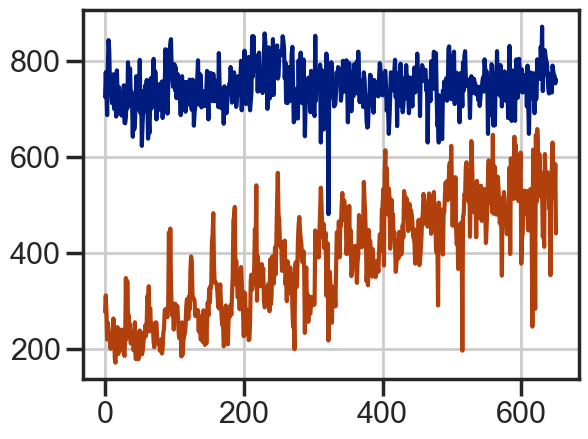

In [35]:
plt.plot(init)
plt.plot(read)

In [ ]:
calibration_bias(voltage_source, 
                                                                              histogram, 
                                                                              key_info=bias_calibration,
                                                                             integration_time_s=integration_time_s,
                                                                              seq_length=data['seq_length'])

# Live Update